# Stanford CME 241 (Winter 2026) - Assignment 1

**Due: Friday, January 23 @ 11:59 PM PST on Gradescope.**

Assignment instructions:
- Make sure each of the subquestions have answers
- Ensure that group members indicate which problems they're in charge of
- Show work and walk through your thought process where applicable
- Empty code blocks are for your use, so feel free to create more under each section as needed
- Document code with light comments (i.e. 'this function handles visualization')

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL and group members below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):*

https://github.com/EthanSei/RL-book/blob/master/Assignments/assignment1.ipynb

*Group members (replace below names with people in your group):*
- Ethan Seide

## Imports

## Question 1: Snakes and Ladders (Led by Ethan Seide)

In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.


### Problem Statement

How can we model this problem with a Markov Process?

---

### Subquestions

#### Part (A): MDP Modeling

Formalize the state space of the Snakes and Ladders game. Don't forget to specify the terminal state!

---

#### Part (B): Transition Probabilities

Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

---

#### Part (C): Modeling the Game

Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces, and plot the graph of the distribution of time steps to finish the game. Use the image provided for the locations of the snakes and ladders.

https://drive.google.com/file/d/1yhP242sG092Ico_WOPKrUp8jVJHbuGHH/view?usp=sharing

---

### Part (A) Answer
For each player, the state space $S$ is the set of whole numbers from 0 to 100, which indicates the current position of the player on the board.

The states ${0,1,2,...,99}$ are non-terminal. State $s=100$ is terminal


### Part (B) Answer

Without the snakes and ladders, the probability matrix would be a six-diagonal matrix where state $i$ has a $\frac{1}{6}$ change of landing on each of $\{i+1,i+2,i+3,i+4,i+5,i+6\}$ (the dice roll).

The exceptions here are state $s_{t} \in [95,99]$. If we roll such that our next position is greater than $100$, then $s_{t+1} = s_{t}$ with probability equal to the number of ways to land a position greater than 100. So for example, position 99 has $\frac{1}{6}$ change of transitioning to position 100 and a $5(\frac{1}{6}) = \frac{5}{6}$ change of staying on 99

Now adding back the snakes and ladders, these are basically portals from map from one position to another. So if without the snakes/ladders, $P(i\rightarrow j) = \epsilon > 0$ for states $i$ and $j$, and $j$ is the head of a snake or the bottom of a ladder to position $k$, then the true transition probabilities have $P(i\rightarrow k) = \epsilon$ and $P(i\rightarrow j) = 0$

### Part (C) Answer

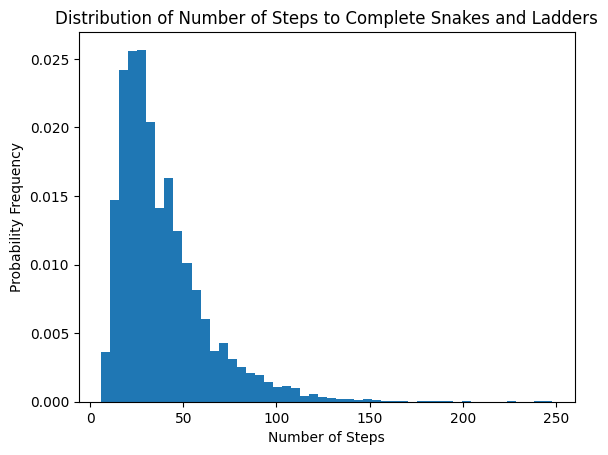

In [72]:
# fill in with Python code
import rl.markov_process as mp
import matplotlib.pyplot as plt
from collections import Counter

def build_transition_map() -> dict[int, mp.FiniteDistribution[int]]:
    snakes: dict[int, int] = {32: 10, 34: 6, 48: 26, 62: 18, 88: 24, 95: 56, 97: 78}  # head -> tail
    ladders: dict[int, int] = {1: 38, 4: 14, 8: 30, 21: 42, 28: 76, 50: 67, 71: 92, 80: 99}  # bottom -> top
    transitions: dict[int, mp.FiniteDistribution[int]] = {}

    for non_terminal in range(0, 100):
        outcomes: dict[int, float] = {}

        for i in range(1, 7):
            outcome = non_terminal + i
            if outcome > 100:  # near 100 outcome
                outcomes[non_terminal] = outcomes.get(non_terminal, 0) + 1 / 6
            elif outcome in ladders:  # ladder outcome
                landing = ladders[outcome]
                outcomes[landing] = outcomes.get(landing, 0) + 1 / 6
            elif outcome in snakes:  # snake outcome
                landing = snakes[outcome]
                outcomes[landing] = outcomes.get(landing, 0) + 1 / 6
            else:
                outcomes[outcome] = outcomes.get(outcome, 0) + 1 / 6

        transitions[non_terminal] = mp.Categorical(outcomes)
    return transitions


transition_map = build_transition_map()
game_mp = mp.FiniteMarkovProcess(transition_map)

start_state_dist = mp.Categorical({mp.NonTerminal(0): 1.0})

trace_gen = game_mp.traces(start_state_dist)

num_traces = 10000
count = 0
simulations = []
for trace in trace_gen:
    if count >= num_traces:
        break
    count += 1
    simulations.append(trace)

num_steps = []
for sim in simulations:
    step_count = sum([1 for _ in sim]) - 1 # remove init state
    num_steps.append(step_count)

counts = Counter(num_steps)
xs = sorted(counts)
ys = [counts[x] / len(num_steps) for x in xs]

plt.hist(num_steps, bins=50, density=True)
plt.xlabel("Number of Steps")
plt.ylabel("Probability Frequency")
plt.title("Distribution of Number of Steps to Complete Snakes and Ladders")
plt.show()

## Question 2: Markov Decision Processes (Led by Ethan Seide)

Consider an MDP with an infinite set of states ${S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by:
$$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in S \text{ for all } a \in [0,1]$$
For all states $s \in {S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Problem Statement

How can we derive a mathematical formulation for the value function and the optimal policy? And how do those functions change when we modify the action space?

---

### Subquestions

#### Part (A): Optimal Value Function  

Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in {S}$. Given $V^*(s)$, what is the optimal action, $a^*$, that maximizes the optimal value function?

---

#### Part (B): Optimal Policy  

Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in {S}$.

---

#### Part (C): Changing the Action Space  

Let's assume that we modify the action space such that instead of $a \in [0,1]$ for all states, we restrict the action space to $a \in \left[0,\frac{1}{s}\right]$ for state $s$. This means that higher states have more restricted action spaces. How does this constraint affect:

- The form of the Bellman optimality equation?
- The optimal value function, $V^*(s)$?
- The structure of the optimal policy, $\pi^*(s)$?

---

### Part (A) Answer

$V^{*}(s) = \max_{a\in [0,1]}\mathbb{E}[ R(s,s',a) + \gamma \sum_{s'}\mathbb{P}(s'|s,a)V^{*}(s')|s,a]$

$Q(s,a) = a(1-a) + (1-a)(1+a) + 0.5[aV^{*}(s+1) + (1-a)V^{*}(s)]$

$Q(s,a) = (1 + a - 2a^2) + 0.5[aV^{*}(s+1) + (1-a)V^{*}(s)]$

Since neither the reward nor transition probability depend on $s$ and we know the Bellman operator is a contraction, this suggests $V*(s) = V$ $\forall s\in S$

So $\max_a Q(s,a) = \max_a [(1 + a - 2a^2)] + 0.5V$. This quadratic $1 + a - 2a^2$ is maximized at $a=\frac{1}{4}$.

This means $V^{*}(s) = V = 1 + \frac{1}{4} - \frac{1}{8} + 0.5V = 2.25$

### Part (B) Answer

Given we know the optimal value is achieved at $a=\frac{1}{4}$ and the optimal value is achieved by following the optimal policy, the optimal policy is:

$\pi^{*}(s) = \frac{1}{4}$ $\forall s\in S$

### Part (C) Answer

#### Bellman Optimality Equation Change:
The new Bellman Optimality Equation is:

$V^{*}(s) = \max_{a\in [0,\frac{1}{s}]}[1 + a - 2a^2 + \frac{1}{2}(aV^{*}(s+1) + (1-a)V^*(s))]$

where the key change is the range of $a$ now being $[0,\frac{1}{s}]$
#### Optimal Value Function Change:
The MDP is still stationary, but the feasible action set depends on $s$, so the problem is no longer translation invariant. As a result, $V^*(s)$ is not constant across states and there is no clean closed-form solution in general, since $aV^*(s+1) + (1-a)V^*(s)$ varies with $s$.


#### Optimal Policy Change:
For the same reason, the optimal action can vary with $s$ and is defined implicitly through the Bellman equation. Thus there is no simple closed-form policy. The policy must be solved together with $V^*(s)$ (typically numerically for the infinite state space).

## Question 3: Frog in a Pond (Led by Ethan Seide)

Consider an array of $n+1$ lilypads on a pond, numbered $0$ to $n$. A frog sits on a lilypad other than the lilypads numbered $0$ or $n$. When on lilypad $i$ ($1 \leq i \leq n-1$), the frog can croak one of two sounds: **A** or **B**.

- If it croaks **A** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to lilypad $i-1$ with probability $\frac{i}{n}$.
  - It is thrown to lilypad $i+1$ with probability $\frac{n-i}{n}$.
  
- If it croaks **B** when on lilypad $i$ ($1 \leq i \leq n-1$):
  - It is thrown to one of the lilypads $0, \ldots, i-1, i+1, \ldots, n$ with uniform probability $\frac{1}{n}$.

A snake, perched on lilypad $0$, will eat the frog if it lands on lilypad $0$. The frog can escape the pond (and hence, escape the snake!) if it lands on lilypad $n$.

### Problem Statement

What should the frog croak when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (i.e., reaching lilypad $n$ before reaching lilypad $0$)?

Although there are multiple ways to solve this problem, we aim to solve it by modeling it as a **Markov Decision Process (MDP)** and identifying the **Optimal Policy**.

---

### Subquestions

#### Part (A): MDP Modeling

Express the frog-escape problem as an MDP using clear mathematical notation by defining the following components:

- **State Space**: Define the possible states of the MDP.
- **Action Space**: Specify the actions available to the frog at each state.
- **Transition Function**: Describe the probabilities of transitioning between states for each action.
- **Reward Function**: Specify the reward associated with the states and transitions.

---

#### Part (B): Python Implementation

There is starter code below to solve this problem programatically. Fill in each of the $6$ `TODO` areas in the code. As a reference for the transition probabilities and rewards, you can make use of the example in slide 16/31 from the following slide deck: https://github.com/coverdrive/technical-documents/blob/master/finance/cme241/Tour-MP.pdf.

Write Python code that:

- Models this MDP.
- Solves the **Optimal Value Function** and the **Optimal Policy**.

Feel free to use/adapt code from the textbook. Note, there are other libraries that are needed to actually run this code, so running it will not do anything. Just fill in the code so that it could run assuming that the other libraries are present.

---

#### Part (C): Visualization and Analysis

What patterns do you observe for the **Optimal Policy** as you vary $n$ from $3$ to $25$? When the frog is on lilypad $13$ (with $25$ total), what action should the frog take? Is this action different than the action the frog should take if it is on lilypad $1$?

---

### Part (A) Answer

#### State Space:  

$S = {0,1,2,...,n}$ representing the lilypad the frog is on.

#### Action Space:  
$A = {A,B}$ representing the two sounds the frog can croak.

#### Transition Function:  

$\mathbb{P}(i \rightarrow i + 1|i,A) = \frac{n-i}{n}$

$\mathbb{P}(i \rightarrow i - 1|i,A) = \frac{i}{n}$

$\mathbb{P}(i \rightarrow i'|i,B) = \frac{1}{n}\forall i' \neq i$

#### Reward Function:  

Define rewards on transitions to avoid infinite return with $\gamma=1$:

$R(i, a, i') = 1$ if $i' = n$ (frog reaches the escape pad),

$R(i, a, i') = 0$ otherwise.

Pads 0 and $n$ are absorbing with zero reward thereafter.

This makes the return equal to the probability of reaching $n$ before 0.

### Part (B) Answer

In [ ]:
MDPRefined = dict
def get_lily_pads_mdp(n: int) -> MDPRefined:
    data = {
        i: {
            'A': {
                i - 1: i / n,
                i + 1: (n-i) / n,
            },
            'B': {
                j: 1 / n if i != j else 0 for j in range(0,n+1)
            }
        } for i in range(1, n)
    }
    data[0] = { 'A': {0:1}, 'B': {0:1} }
    data[n] = { 'A': {n:1}, 'B': {n:1} }

    gamma = 1.0
    return MDPRefined(data, gamma)

Mapping = dict
def direct_bellman(n: int) -> Mapping[int, float]:
    vf = [(0.5, 'A') for _ in range(n + 1)]
    vf[0] = (0., 'A')
    vf[n] = (1., 'A')
    tol = 1e-8
    epsilon = tol * 1e4
    while epsilon >= tol:
        old_vf = [v for v in vf]
        for i in range(1, n):
            A_val = (i/n) * old_vf[i-1][0] + ((n-i)/n) * old_vf[i+1][0]
            B_val = 1/n * sum([old_vf[j][0] for j in range(0,n+1) if j != i])
            if A_val >= B_val:
                a = 'A'
            else:
                a = 'B'
            vf[i] = (max(A_val, B_val), a)
        epsilon = max(abs(old_vf[i][0] - v[0]) for i, v in enumerate(vf))
    return {v: f for v, f in enumerate(vf)}

In [71]:
direct_bellman(15)

{0: (0.0, 'A'),
 1: (0.6708263038140964, 'B'),
 2: (0.6908274236127467, 'A'),
 3: (0.6939045302164509, 'A'),
 4: (0.694673819279388, 'A'),
 5: (0.6949535743570877, 'A'),
 6: (0.6950934668785835, 'A'),
 7: (0.6951867452174371, 'A'),
 8: (0.6952683825094178, 'A'),
 9: (0.6953617036973574, 'A'),
 10: (0.6955017104746946, 'A'),
 11: (0.6957817540158893, 'A'),
 12: (0.6965519112084938, 'A'),
 13: (0.6996325897976968, 'A'),
 14: (0.7196570746044417, 'A'),
 15: (1.0, 'A')}

### Part (C) Answer

For the MDPs with $n\in[3,25]$, it generally appears (from value-iteration runs) to be optimal to croak B on lilypad 1 and croak A on all other lilypads. This depends on the reward values, but is typically seen when $R(n,a) > R(0,a)$.

When the frog is on lilypad 13, the frog should likely take action A. This is because there's a relatively high penalty for action B since the frog has a $\frac{1}{n}$ chance of landing on lilypad 0.

On lilypad 1, action B is often optimal in these runs because it keeps the same $\frac{1}{n}$ risk of landing on 0 while adding a $\frac{1}{n}$ chance of jumping directly to $n$.

## Question 4: Manual Value Iteration (Led by Ethan Seide)

Consider a simple MDP with ${S} = \{s_1, s_2, s_3\}, {T} = \{s_3\}, {A} = \{a_1, a_2\}$. The State Transition Probability function  
$${P}: {N} \times {A} \times {S} \rightarrow [0, 1]$$  
is defined as:  
$${P}(s_1, a_1, s_1) = 0.25, {P}(s_1, a_1, s_2) = 0.65, {P}(s_1, a_1, s_3) = 0.1$$  
$${P}(s_1, a_2, s_1) = 0.1, {P}(s_1, a_2, s_2) = 0.4, {P}(s_1, a_2, s_3) = 0.5$$  
$${P}(s_2, a_1, s_1) = 0.3, {P}(s_2, a_1, s_2) = 0.15, {P}(s_2, a_1, s_3) = 0.55$$  
$${P}(s_2, a_2, s_1) = 0.25, {P}(s_2, a_2, s_2) = 0.55, {P}(s_2, a_2, s_3) = 0.2$$  

The Reward Function  
$${R}: {N} \times {A} \rightarrow \mathbb{R}$$  
is defined as:  
$${R}(s_1, a_1) = 8.0, {R}(s_1, a_2) = 10.0$$  
$${R}(s_2, a_1) = 1.0, {R}(s_2, a_2) = -1.0$$  

Assume a discount factor of $\gamma = 1$.

### Problem Statement

Your task is to determine an Optimal Deterministic Policy **by manually working out** (not with code) the first two iterations of the Value Iteration algorithm.

---

### Subquestions

#### Part (A): 2 Iterations

1. Initialize the Value Function for each state to be its $\max$ (over actions) reward, i.e., we initialize the Value Function to be $v_0(s_1) = 10.0, v_0(s_2) = 1.0, v_0(s_3) = 0.0$. Then manually calculate $q_k(\cdot, \cdot)$ and $v_k(\cdot)$ from $v_{k - 1}(\cdot)$ using the Value Iteration update, and then calculate the greedy policy $\pi_k(\cdot)$ from $q_k(\cdot, \cdot)$ for $k = 1$ and $k = 2$ (hence, 2 iterations).

---

#### Part (B): Argument

1. Now argue that $\pi_k(\cdot)$ for $k > 2$ will be the same as $\pi_2(\cdot)$. *Hint*: You can make the argument by examining the structure of how you get $q_k(\cdot, \cdot)$ from $v_{k-1}(\cdot)$. With this argument, there is no need to go beyond the two iterations you performed above, and so you can establish $\pi_2(\cdot)$ as an Optimal Deterministic Policy for this MDP.

---

#### Part (C): Policy Evaluation

1. Using the policy $\pi_2(\cdot)$, compute the exact value function $V^{\pi_2}(s)$ for all $s\in S$.

---

#### Part (D): Sensitivity Analysis

Assume the reward for $R(s_1, a_2)$ is modified to $11.0$ instead of $10.0$.

1. Perform one iteration of Value Iteration starting from the initialized value function $v_0(s)$, where $v_0(s)$ remains the same as in the original problem.
2. Determine whether this change impacts the Optimal Deterministic Policy $\pi(\cdot)$. If it does, explain why.

---

### Part (A) Answer

$v_0 = [10,1,0]$

$q_k(s_i,a_j) = R(s_i,a_j) + (1.0)\sum_{s'}[P(s_i, a_j, s')v_{k-1}(s)]$

$q_1(s_1,a_1) = 8 + [0.25(10) + 0.65(1) + 0.1(0)] = 11.15\\
q_1(s_1,a_2) = 10 + [0.1(10) + 0.4(1) + 0.5(0)] = 11.4\\
v_1(s_1) = \max[q_1(s_2,a_1),q_1(s_2,a_2)] = 11.4 (a_2)\\
q_1(s_2,a_1) = 1 + [0.3(10) + 0.15(1) + 0.55(0)] = 4.15\\
q_1(s_2,a_2) = -1 + [0.25(10) + 0.55(1) + 0.2(0)] = 2.05\\
v_1(s_2) = \max[q_1(s_2,a_1),q_1(s_2,a_2)] = 4.15 (a_1)\\$

Then: $v_1 = [11.4,4.15,0]$.

The optimal greedy policy is: $\pi_1^*(s_1)=a_2$ and $\pi_1^*(s_2)=a_1$

$q_1(s_1,a_1) = 8 + [0.25(11.4) + 0.65(4.15) + 0.1(0)] = 13.5475\\
q_1(s_1,a_2) = 10 + [0.1(11.4) + 0.4(4.15) + 0.5(0)] = 12.8\\
v_2(s_1) = \max[q_1(s_2,a_1),q_1(s_2,a_2)] = 13.5475 (a_1)\\
q_2(s_2,a_1) = 1 + [0.3(11.4) + 0.15(4.15) + 0.55(0)] = 5.0425\\
q_2(s_2,a_2) = -1 + [0.25(11.4) + 0.55(4.15) + 0.2(0)] = 4.1325\\
v_2(s_2) = \max[q_2(s_2,a_1),q_2(s_2,a_2)] = 5.0425 (a_1)\\$

Then: $v_2 = [13.5475, 5.0425, 0]$. 

The optimal greedy policy is: $\pi_2^*(s_1)=a_1$ and $\pi_2^*(s_2)=a_1$

### Part (B) Answer:  

$\Delta(s_1) = q(s_1,a_1) - q(s_1,a_2) = -2 + 0.15v(s_1) + 0.25v(s_2) - 0.4(0)$

If we plug in $v_2$ values, then we see:
$\Delta_2(s_1) = 1.29 > 0$

Since $\Delta(s_1)$ is already positive and $\frac{\delta q(s_1,a)}{\delta v(s_1)} > 0$ $\forall a$ and $\frac{\delta q(s_2,a)}{\delta v(s_2)} > 0$ $\forall a$, the optimal v will have $v^*(s_1) >= v_2(s_1)$ and $v^*(s_2) >= v_2(s_2)$. Since the coefficients in front of $v(s_1)$ and $v(s_2)$ in $\Delta(s_1)$ equation are positive, this means the first equation is always positive for $\forall k >= 2$

### Part (C) Answer:
Since we always take action $a_1$ in policy $\pi_2(\cdot)$, we can solve the set of linear equations to determine the optimal values.

We also know that $V^\pi(s_3) = 0$

$V^{\pi_2}(s_1) = 8 + 0.25V^{\pi_2}(s_1) + 0.65V^{\pi_2}(s_2) + 0\\
V^{\pi_2}(s_2) = 1 + 0.3V^{\pi_2}(s_1) + 0.15V^{\pi_2}(s_2) + 0$

Using simple Gaussian Elimination to solve the system above:

$V^{\pi_2}(s_1) = 16.836\\
V^{\pi_2}(s_2) = 7.119\\
V^{\pi_2}(s_3) = 0$


### Part (D) Answer

#### Value Iteration:  

$v_0 = [10,1,0]$

$q_k(s_i,a_j) = R(s_i,a_j) + (1.0)\sum_{s'}[P(s_i, a_j, s')v_{k-1}(s)]$

$q_1(s_1,a_1) = 8 + [0.25(10) + 0.65(1) + 0.1(0)] = 11.15\\
q_1(s_1,a_2) = 11 + [0.1(10) + 0.4(1) + 0.5(0)] = 12.4\\
v_1(s_1) = \max[q_1(s_2,a_1),q_1(s_2,a_2)] = 12.4 (a_2)\\
q_1(s_2,a_1) = 1 + [0.3(10) + 0.15(1) + 0.55(0)] = 4.15\\
q_1(s_2,a_2) = -1 + [0.25(10) + 0.55(1) + 0.2(0)] = 2.05\\
v_1(s_2) = \max[q_1(s_2,a_1),q_1(s_2,a_2)] = 4.15 (a_1)\\$

Then: $v_1 = [12.4,4.15,0]$.

The optimal greedy policy is: $\pi_1^*(s_1)=a_2$ and $\pi_1^*(s_2)=a_1$
#### Optimal Deterministic Policy:  

Similar to the argument made in Part B, since this modification only affects the policy for $s_1$ and the modified $\Delta_k(s_1) = -3 + 0.15v(s_1) + 0.25v(s_2) > 0$ for the point $(v(s_1) = 16.836, v(s_2) = 7.119)$, then at some $k$, $\Delta_k(s_1)$ becomes positive and stays positive.

This means the optimal policy is still $\pi^*(s_1) = a_1$ even with the perturbation

## Question 5: Fixed-Point and Policy Evaluation True/False Questions (Led by Ethan Seide)

### Recall Section: Key Formulas and Definitions

#### Bellman Optimality Equation
The Bellman Optimality Equation for state-value functions is:
$$
V^*(s) = \max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^*(s') \right].
$$
For action-value functions:
$$
Q^*(s, a) = R(s, a) + \gamma \sum_{s'} P(s, a, s') \max_{a'} Q^*(s', a').
$$

#### Contraction Property
The Bellman Policy Operator $B^\pi$ is a contraction under the $L^\infty$-norm:
$$
\|B^\pi(X) - B^\pi(Y)\|_\infty \leq \gamma \|X - Y\|_\infty.
$$
This guarantees convergence to a unique fixed point.

#### Policy Iteration
Policy Iteration alternates between:
1. **Policy Evaluation**: Compute $V^\pi$ for the current policy $\pi$.
2. **Policy Improvement**: Generate a new policy $\pi'$ by setting:
   $$
   \pi'(s) = \arg\max_a \left[ R(s, a) + \gamma \sum_{s'} P(s, a, s') V^\pi(s') \right].
   $$

#### Discounted Return
The discounted return from time step $t$ is:
$$
G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i,
$$
where $\gamma \in [0, 1)$ is the discount factor.

### True/False Questions (Provide Justification)

1. **True/False**: If $Q^\pi(s, a) = 5$, $P(s, a, s') = 0.5$ for $s' \in \{s_1, s_2\}$, and the immediate reward $R(s, a)$ increases by $2$, the updated action-value function $Q^\pi(s, a)$ also increases by $2$.


---

2. **True/False**: For a discount factor $\gamma = 0.9$, the discounted return for rewards $R_1 = 5, R_2 = 3, R_3 = 1$ is greater than $6$.

---

3. **True/False**: The Bellman Policy Operator $B^\pi(V) = R^\pi + \gamma P^\pi \cdot V$ satisfies the contraction property for all $\gamma \in [0, 1)$, ensuring a unique fixed point.

---

4. **True/False**: In Policy Iteration, the Policy Improvement step guarantees that the updated policy $\pi'$ will always perform strictly better than the previous policy $\pi$.

---

5. **True/False**: If $Q^\pi(s, a) = 10$ for all actions $a$ in a state $s$, then the corresponding state-value function $V^\pi(s) = 10$, regardless of the policy $\pi$.

---

6. **True/False**: The discounted return $G_t = \sum_{i=t+1}^\infty \gamma^{i-t-1} R_i$ converges to a finite value for any sequence of bounded rewards if $\gamma < 1$.

---

### Answers (Provide justification, brief explanations are fine)

#### Question 1: 

$Q^\pi(s,a) = R(s,a) + \gamma\sum P(s,a,s')V^\pi(s')$

False in general. We can't guarantee that changing the reward doesn't change the value function $V^\pi(s')$ for some values of $s'$, which could change the Q-value function more than just the immediate reward.

However, if $V^\pi(s)$ is unaffected by the change in Q value, then False.

#### Question 2:

True assuming $R_k = 0$ $\forall k > 3$

$G_t = \sum_{i=t+1}\gamma^{i-t-1}R_i$

$G_0 = R_1 + \gamma R_2 + \gamma^2 R_3\\
G_0 = 5 + 0.9*3 + 0.81*1\\
G_0 = 8.51$

(Note: False if later reward timestamps can be negative which could bring down the return.)

#### Question 3:  

True (assuming finite state space)

Using the $L^\infty$ norm:

$\forall X, Y \in \mathbb{R}^m$,

$\max_{s\in\mathbb{N}}|(B^\pi(X) - B\pi(Y))(s)| = \gamma\max_{s\in\mathbb{N}}|(P^\pi (X - Y))(s)| \leq \gamma\max_{s\in\mathbb{N}}|(X-Y)(s)|$ since $P^\pi$ is a transition probability matrix with unit row sums. 

This means as long as $\gamma \lt 1$, $B^\pi$ has the contraction property, meaning it has a unique fixed point.
#### Question 4:  

False, this step guarantees $\pi$' will perform weakly better than the previous policy $\pi$.

If you are already at the optimal value function, then the value function is at a fixed point, so there is no way to further improve the policy. Generating the next step will produce the same policy, thus $\pi' = \pi$
#### Question 5:  

True, $V^\pi(s) = max_a Q^\pi(s,a)$ so if $Q^\pi(s,a) = 10 \forall a$, then $V^\pi(s) = max_a 10 = 10$

#### Question 6:  

True. The discounted return with $\gamma < 1$ is the sum of a geometric sequence, which is guaranteed to converge

(note, this assumes $\gamma >= 0$. If $\gamma < -1$, then this will diverge)